In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import torch
import os
import sys

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate

# Conjugate Gaussian Mean Inference

We consider the problem of inferring the **unknown mean** $\mu$ of a Gaussian distribution, given observed data $y_1, \dots, y_n$.

---

## 1. Likelihood

The data is generated according to:

$$
y_i \sim \mathcal{N}(\mu, \sigma^2), \quad i = 1, \dots, n
$$

where:
- $\mu$ is the unknown mean,
- $\sigma^2$ is the known variance (observation noise).

The likelihood is:

$$
p(y_1, \dots, y_n \mid \mu) = \prod_{i=1}^n \mathcal{N}(y_i \mid \mu, \sigma^2)
$$

---

## 2. Prior

We place a **Gaussian prior** on $\mu$:

$$
\mu \sim \mathcal{N}(\mu_0, \tau^2)
$$

where:
- $\mu_0$ is the prior mean,
- $\tau^2$ is the prior variance.

This is conjugate to the Gaussian likelihood, so the posterior will also be Gaussian.

---

## 3. Posterior

By Bayes’ Rule:

$$
p(\mu \mid \mathbf{y}) \propto p(\mathbf{y} \mid \mu) \cdot p(\mu)
$$

The posterior is:

$$
\mu \mid \mathbf{y} \sim \mathcal{N}(\mu_{\text{post}}, \sigma_{\text{post}}^2)
$$

Where:

$$
\sigma_{\text{post}}^2 = \left( \frac{n}{\sigma^2} + \frac{1}{\tau^2} \right)^{-1}
$$

$$
\mu_{\text{post}} = \sigma_{\text{post}}^2 \left( \frac{n \bar{y}}{\sigma^2} + \frac{\mu_0}{\tau^2} \right)
$$

with:

$$
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i
$$

---

## 4. Interpretation

The posterior mean $\mu_{\text{post}}$ is a **precision-weighted average** of:
- the sample mean $\bar{y}$, and
- the prior mean $\mu_0$

Weights:
- Likelihood precision: $\frac{n}{\sigma^2}$
- Prior precision: $\frac{1}{\tau^2}$

As $n \to \infty$ or $\sigma^2 \to 0$, the posterior is dominated by the data.

---

## 5. Posterior Sampling

To sample from the posterior:

$$
\mu^{(i)} \sim \mathcal{N}(\mu_{\text{post}}, \sigma_{\text{post}}^2), \quad i = 1, \dots, N_{\text{samples}}
$$

These samples can be used to construct posterior predictions or evaluate metrics like Pokie.

---

## 6. Summary Table

| Quantity            | Formula |
|---------------------|---------|
| Likelihood          | $y_i \sim \mathcal{N}(\mu, \sigma^2)$ |
| Prior               | $\mu \sim \mathcal{N}(\mu_0, \tau^2)$ |
| Posterior Mean      | $\mu_{\text{post}} = \left( \frac{n}{\sigma^2} + \frac{1}{\tau^2} \right)^{-1} \left( \frac{n \bar{y}}{\sigma^2} + \frac{\mu_0}{\tau^2} \right)$ |
| Posterior Variance  | $\sigma_{\text{post}}^2 = \left( \frac{n}{\sigma^2} + \frac{1}{\tau^2} \right)^{-1}$ |
| Posterior Samples   | $\mu^{(i)} \sim \mathcal{N}(\mu_{\text{post}}, \sigma_{\text{post}}^2)$ |

In [2]:
# -------------------------------
# CONFIGURATION
# -------------------------------
num_gt = 500              # Number of ground truth parameters
num_samples = 500         # Samples from posterior
n = 100                   # Number of observed data points per ground truth
true_sigma = 1.0          # Observation noise
prior_mu = 0.0
prior_tau = 1.0           # Prior standard deviation
noise_levels = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
num_noise_levels = len(noise_levels)

# -------------------------------
# Storage
# -------------------------------
ground_truths = np.random.uniform(-5, 5, size=(num_gt, 1))  # True means
posteriors = np.zeros((num_noise_levels, num_gt, num_samples, 1))  # 1D inference

# -------------------------------
# Posterior Sampling Loop
# -------------------------------
for gt_idx in tqdm(range(num_gt), desc='Sampling Posteriors'):
    mu_star = ground_truths[gt_idx, 0]

    # Generate noisy observations
    y_obs = np.random.normal(mu_star, true_sigma, size=n)
    y_bar = np.mean(y_obs)

    # Posterior parameters
    prec_likelihood = n / (true_sigma ** 2)
    prec_prior = 1 / (prior_tau ** 2)
    prec_post = prec_likelihood + prec_prior

    mu_post = (prec_likelihood * y_bar + prec_prior * prior_mu) / prec_post
    sigma_post = np.sqrt(1 / prec_post)

    for nl_idx, scale in enumerate(noise_levels):
        # Bias magnitude becomes the amount of shift
        shift_direction = 1.0  # or alternate sign per model if desired
        delta = shift_direction * np.sqrt(scale) # e.g., 0.0 → 0.25 shift

        biased_mean = mu_post + delta
        samples = np.random.normal(biased_mean, sigma_post, size=(num_samples, 1))

        posteriors[nl_idx, gt_idx] = samples

Sampling Posteriors: 100%|██████████| 500/500 [00:00<00:00, 13577.75it/s]


In [3]:
gt_norm = np.zeros_like(ground_truths)
posterior_norm = np.zeros_like(posteriors)

for gt_idx in range(num_gt):
    all_posteriors = np.vstack([posteriors[nl_idx, gt_idx] for nl_idx in range(num_noise_levels)])
    combined = np.vstack([all_posteriors, ground_truths[gt_idx][None, :]])

    min_val = np.min(combined, axis=0)
    max_val = np.max(combined, axis=0)
    scale = np.maximum(max_val - min_val, 1e-8)

    gt_norm[gt_idx] = (ground_truths[gt_idx] - min_val) / scale
    for nl_idx in range(num_noise_levels):
        posterior_norm[nl_idx, gt_idx] = (posteriors[nl_idx, gt_idx] - min_val) / scale

In [4]:
# -------------------------------
# Pokie Evaluation
# -------------------------------
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
posterior_norm   = torch.tensor(posterior_norm, dtype=torch.float32, device=device)
gt_norm = torch.tensor(gt_norm,   dtype=torch.float32, device=device)


results, calibrated, n_over_N_vals = pokie(
    gt_norm, posterior_norm, num_runs=100
)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print("Noise Levels:", noise_levels)
print("Raw Pokie:", results)
print("Calibrated Pokie:", calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 247.11it/s]

Noise Levels: [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
Raw Pokie: [0.19221818 0.18375525 0.1584566  0.15548685 0.15519701 0.15488614]
Calibrated Pokie: [0.65475076 0.62592363 0.5397491  0.5296333  0.528646   0.52758706]


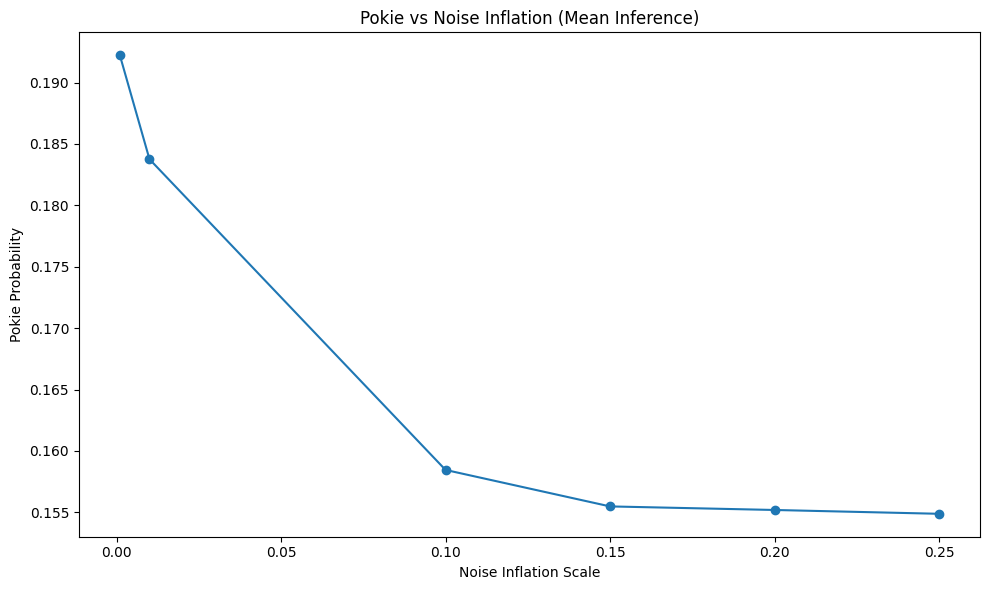

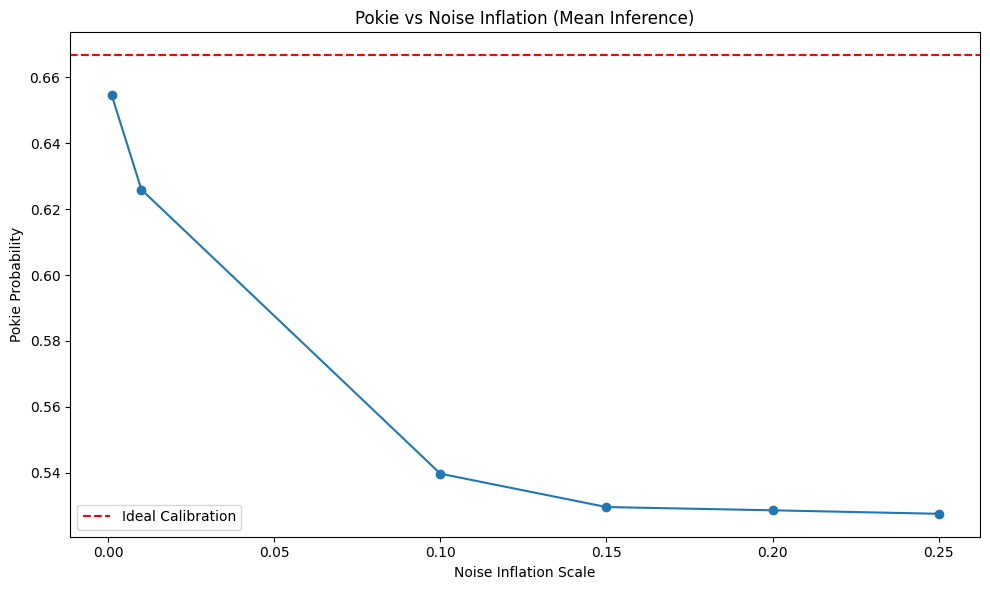

In [5]:
# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (Mean Inference)')
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Mean_Inference.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, calibrated, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (Mean Inference)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Mean_Inference_Calibrated.pdf")
plt.show()

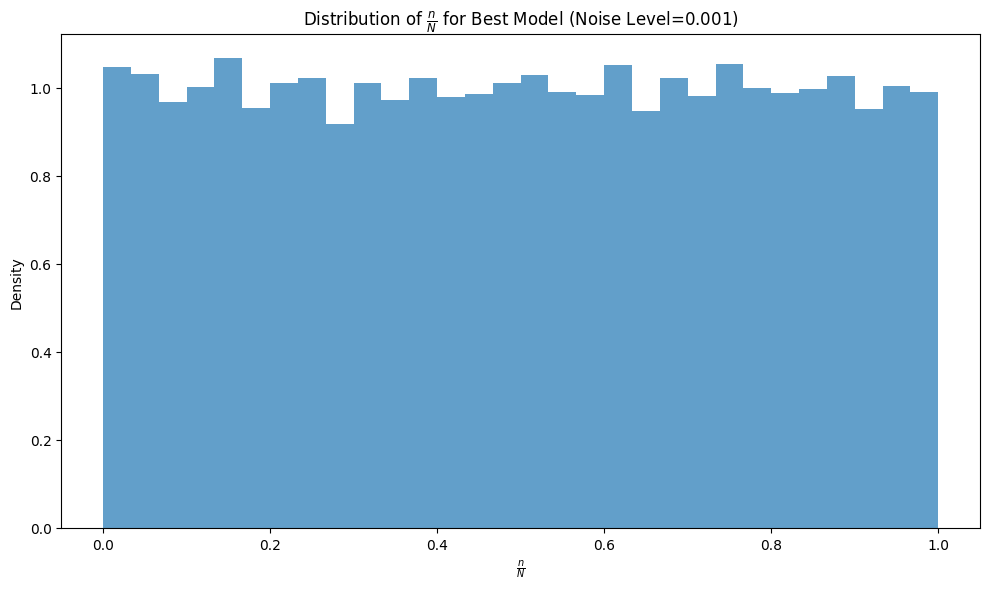

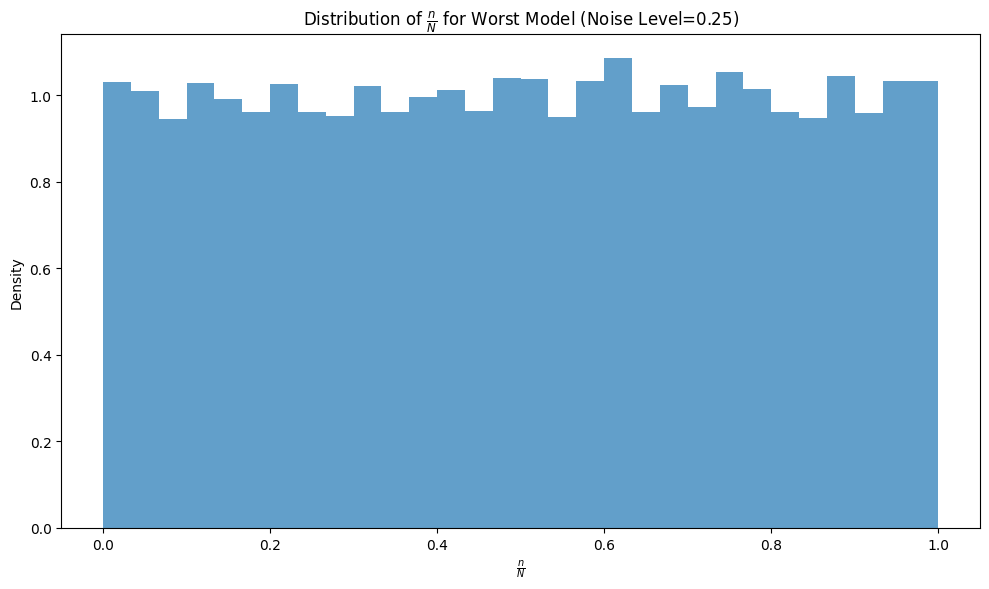

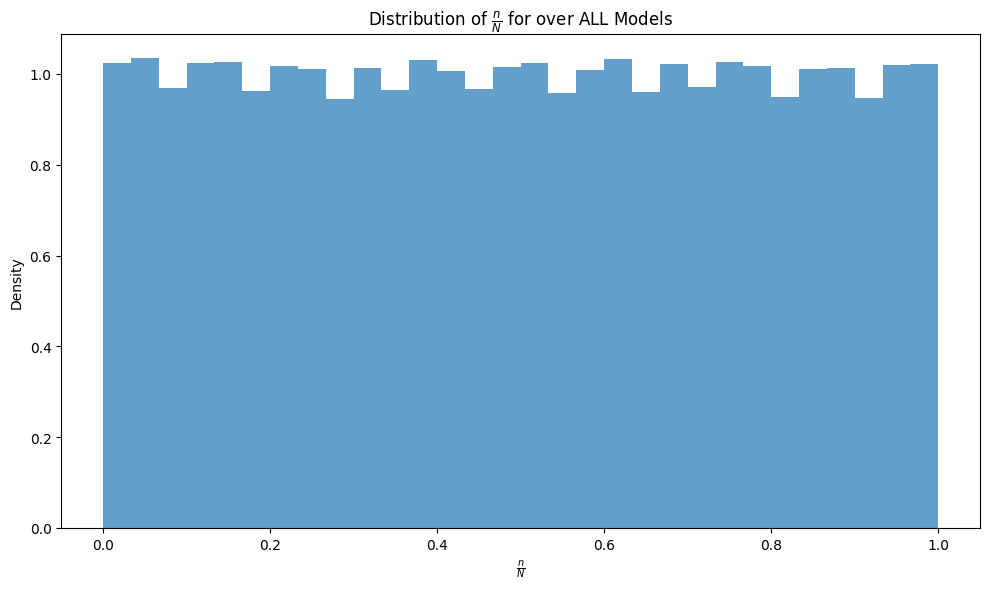

In [6]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (Noise Level={noise_levels[best_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Best_Model_n_over_N_Mean_Inference.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (Noise Level={noise_levels[worst_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Worst_Model_n_over_N_Mean_Inference.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_n_over_N_Mean_Inference.pdf")
plt.show()

In [7]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(gt_norm, posterior_norm, num_runs = 100)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 370.04it/s]

Modes: [0. 1. 2. 3. 4. 5.]
Emperical Pokie: [0.19242676 0.18424438 0.15743099 0.15586205 0.15528256 0.15475327]
Theoretical Pokie: [0.66634494 0.66679436 0.66692364 0.6663716  0.66670305 0.6667096 ]
Convergence Gap: [0.01116639 0.03947526 0.13089937 0.1356892  0.13799387 0.13980246]


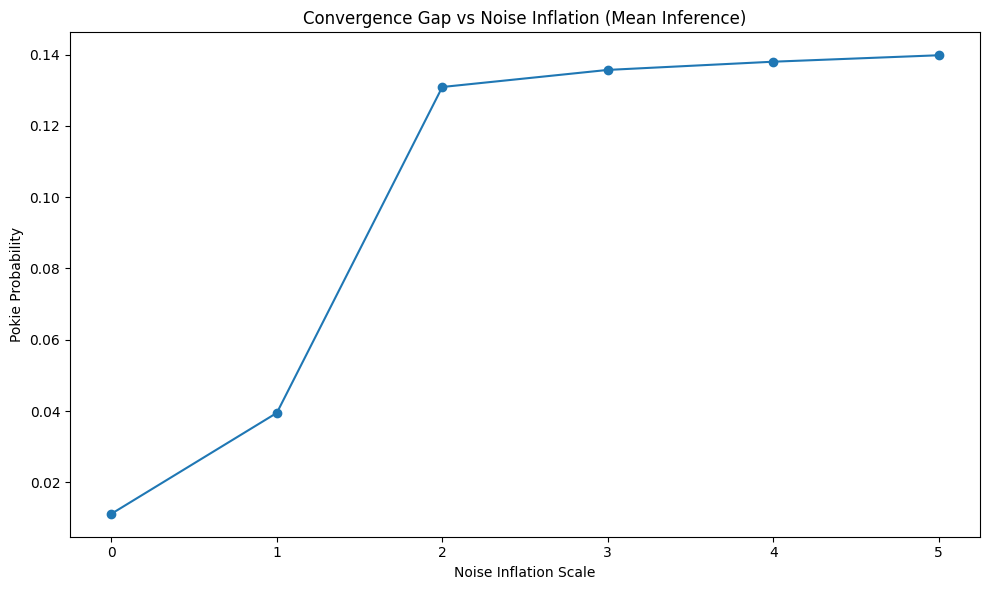

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (Mean Inference)')
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Convergence_Gap_Mean_Inference.pdf")
plt.show()

E[lambda]: 0.500298261642456
E[lambda^2]: 0.33380407094955444


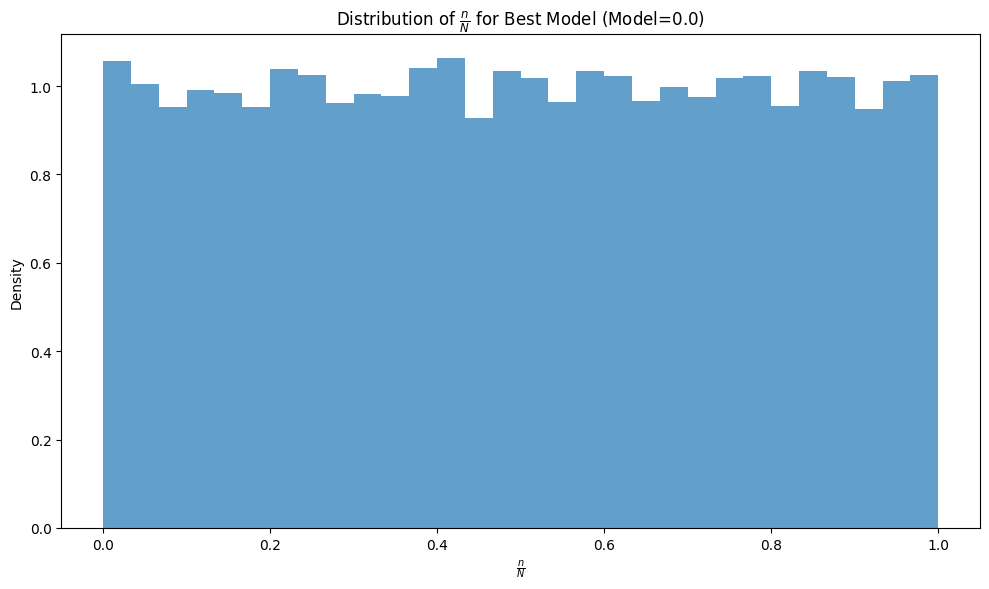

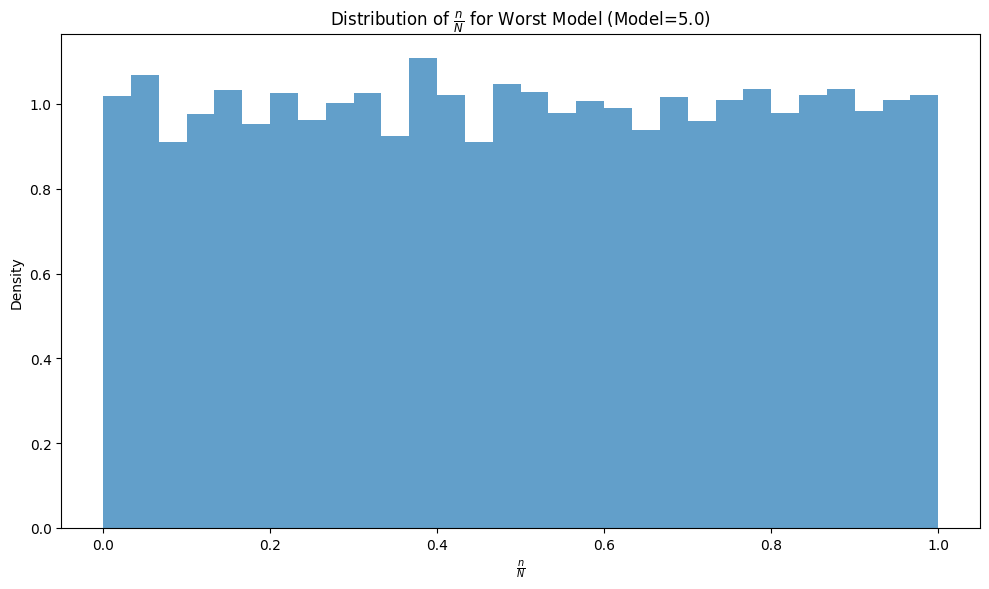

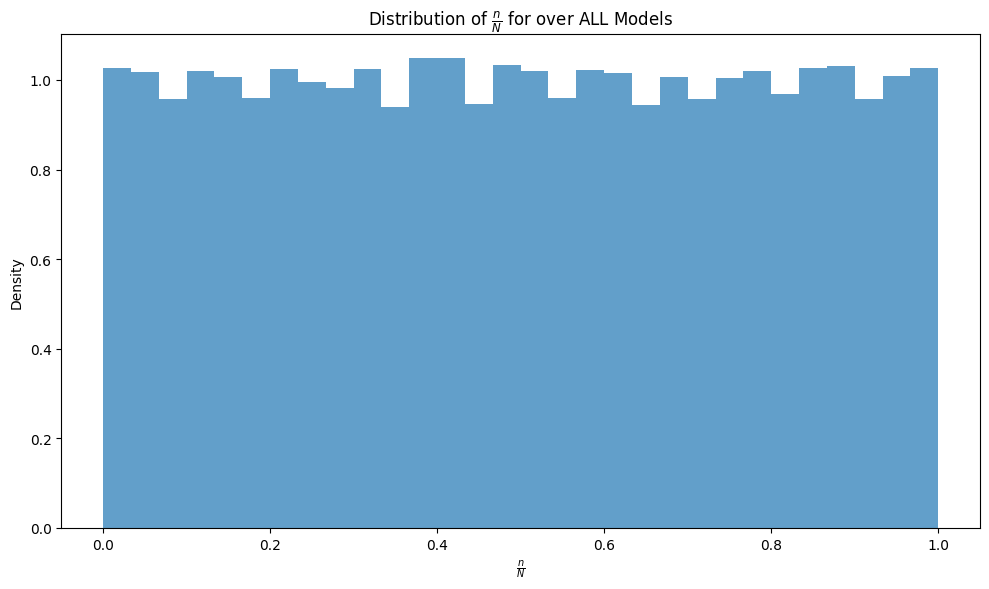

In [9]:
# Identify the best model
best_model_idx = np.argmin(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

print("E[lambda]:", out["E_lambda"][best_model_idx].item())
print("E[lambda^2]:", out["E_lambda_sq"][best_model_idx].item())

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (Model={l_values[best_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Convergence_Best_Model_n_over_N_Mean_Inference.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmax(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (Model={l_values[worst_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Convergence_Worst_Model_n_over_N_Mean_Inference.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Mean_Inference/Pokie_Convergence_n_over_N_Mean_Inference.pdf")
plt.show()